# Demo of iterative reconstruction

In [1]:
%matplotlib inline
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

import random

import torch
import torch.nn as nn 
import torch.nn.functional as F

# Importing iterative reconstruction function
from extraCode.iterativeReconApp import iterative_recons, forward_fanBeam

## Paths used for loading the data

In [2]:
dataDir = "./data/slicesCT.h5"

## Main parameters to be controled by the agorithm
you can select which CNN, how many iterations and the regularization value regVal, which is defined as beta in the paper

In [3]:
which_cnn = "DHSN1"
which_scan = "N051"
iters = 70
regVal = 0.03

## Reconstruction parameters
This is the definintion of the main geometrical parameters to be used for reconstruction. All the variables are stored in a dictionary for better code readability

In [4]:
im_rows = 512
im_cols = 512

dis_src_iso = 595 # [mm]
dis_iso_det = 490.6 # [mm]

det_pix_size = 0.5*(dis_src_iso+dis_iso_det)/dis_src_iso # [mm]
det_count = np.int(3*np.sqrt(im_rows**2+im_cols**2)/det_pix_size) # No elems detector
angles = np.linspace( 2*np.pi,0,num=720, endpoint=False)[0:440] # 220 deg. Spacing 0.5 deg

rec_params = {
    "detector":{
        "pix_size": det_pix_size,
        "no_elems": det_count,
    },
    "geometry":{
        "dis_src_iso":dis_src_iso,
        "dis_iso_det":dis_iso_det,
        "angles":angles
    }
}

## Selecting CNN to be used

In [5]:
# Importing cnn models
from cnns.dhsn1 import dhsn1_2d
from cnns.dhsn2 import dhsn2_2d
from cnns.FBPConvNet import FBPConvNet_2d
from cnns.red import red_2d

# Instantiating networks
# Selecting which CNN to use as regularizer
if which_cnn == "DHSN2":
    cnn = dhsn2_2d(1, 3).float().cuda()
    cnn.load_state_dict(torch.load( "./models/dhsn2_L1_25.pyt" ))
    cnn.eval();
if which_cnn == "DHSN1":
    cnn = dhsn1_2d(1, 3).float().cuda()
    cnn.load_state_dict(torch.load( "./models/dhsn1_L1_25_new.pyt" ))
    cnn.eval();
elif which_cnn == "RED":
    cnn = red_2d(96).float().cuda()
    cnn.load_state_dict(torch.load( "./models/ed_red_L1_25_new.pyt" ))
    cnn.eval();
elif which_cnn == "FBPConvNet":
    cnn = FBPConvNet_2d(1, 3, 4).float().cuda()
    cnn.load_state_dict(torch.load( "./models/fbpnet_max_L1_25.pyt" ))
    cnn.eval();

In [6]:
import matplotlib.pyplot as plt
from scriptsForFigures.scriptsImagesNoiseReduction import displaySlice
import h5py

def demoItRecons(which_scan, iters, im_rows, im_cols, rec_params, cnn, regVal=0.02):
    
    
    dispDat = {
        "N051":{"xc":340, "yc":200, "of": 80},
        "N188":{"xc":340, "yc":180, "of": 80},
        "N198":{"xc":270, "yc":315, "of": 80},
        "N138":{"xc":255, "yc":135, "of": 80},
        "N153":{"xc":250, "yc":250, "of": 80},
    }
    
    # Loading slice
    with h5py.File(dataDir, 'r') as f:
        qdct = f["%s_qdct"%(which_scan)][:]
        fdct = f["%s_fdct"%(which_scan)][:]
    
    
    # If the projection data would come from a CT scanner it wouldn't
    # be in Hounsfield Units. Therefore we return the intensity
    # to attenuation values relative to air-scan conditions
    # as it would be in a real CT scanner
    muw=0.2
    imgNoHU = muw*qdct/1000 +muw
    # Generating sinogram by forward-projecting
    sino = forward_fanBeam(
        imgNoHU,
        rec_params)
    
    # We first do an iterative reconstruction without regularization
    noisy, fbp = iterative_recons(
        sino, iters, im_rows, im_cols, rec_params, [], reg=False, regVal=0)
    # Now we perform the regularized reconstruction with the desired CNN
    reg, _, = iterative_recons(
        sino, iters, im_rows, im_cols, rec_params, cnn, reg=True, regVal=regVal)
    
    # Displaying result
    sc=3
    zoom=2
    vmin=0; vmax=80
    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(sc*3,sc*1.11))
    displaySlice(
        noisy, fdct,
        axs[0],
        dispDat[which_scan]["xc"], dispDat[which_scan]["yc"],
        dispDat[which_scan]["of"], zoom, vmin, vmax,
        meas=True, isRef= False)
                 
    displaySlice(
        reg, fdct,
        axs[1], dispDat[which_scan]["xc"], dispDat[which_scan]["yc"],
        dispDat[which_scan]["of"], zoom, vmin, vmax,
        meas=True, isRef= False)
                 
    displaySlice(
        fdct, fdct,
        axs[2], dispDat[which_scan]["xc"], dispDat[which_scan]["yc"],
        dispDat[which_scan]["of"], zoom, vmin, vmax,
        meas=False, isRef= True)
    
    plt.subplots_adjust(wspace=0, hspace= 0.0)
    plt.show()
    return(None)

## Computing the image estimates

/home/s152030/NEXIS/dev/imageDenoising/TIP/DEMO/scriptsForFigures/scriptsImagesNoiseReduction.py:37: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  gradient=True, full=True)


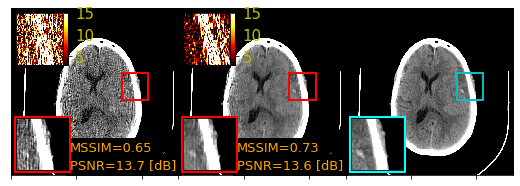

In [7]:
demoItRecons(which_scan, iters, im_rows, im_cols, rec_params, cnn, regVal)